In [2]:
import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# Step 1: Vanishing line detection
def detect_vanishing_line(Ir_image):
    # Perform vanishing line detection using the normal distribution
    # Return the vanishing line coordinates
    gray=cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    edges=cv.Canny(gray,50,150,apertureSize=3)
    lines = cv.HoughLines(edges, 1, np.pi/180, 200)
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv.line(img1,(x1,y1),(x2,y2),(0,0,255),2)
    vanishing_line = Ir_image

    return vanishing_line

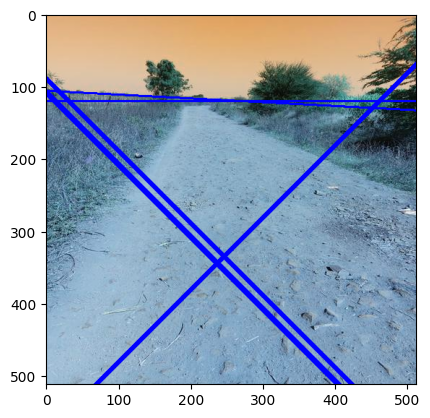

In [3]:
img1 = cv.imread('Image12.jpg')
vanishing_img=detect_vanishing_line(img1)
plt.imshow(vanishing_img)

In [4]:
def segment_image(infrared_image):
    # Perform image segmentation using the double-Otsu algorithm
    # Return the segmented image
    gray = cv.cvtColor(infrared_image, cv.COLOR_BGR2GRAY)
    # Apply median filter for Smoothing the image  
    gray = cv.medianBlur(gray, 5)
    # Apply double-Otsu thresholding to segment the image
    _, segmented_image = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return segmented_image

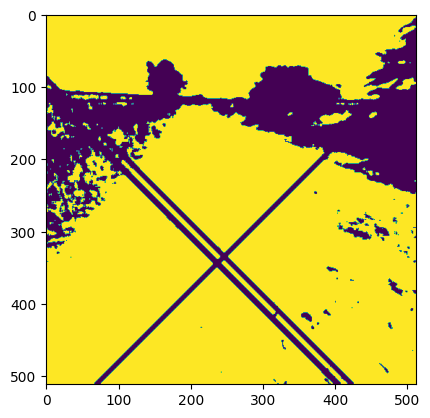

In [5]:
# Step 2: Image segmentation
segmented_image = segment_image(vanishing_img)

# Display the segmented image
plt.imshow(segmented_image)

In [6]:
# Remove small clusters
kernel = np.ones((5,5),np.uint8)
opening = cv.morphologyEx(segmented_image,cv.MORPH_OPEN,kernel, iterations = 3) #First perfom Erosion then Dilation

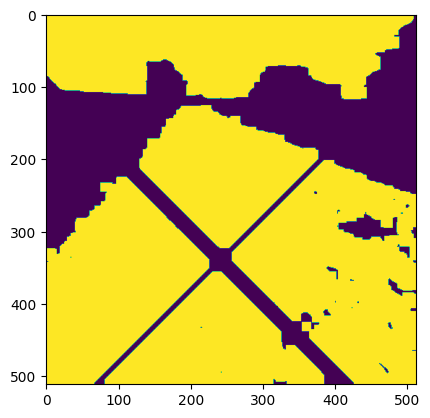

In [7]:
plt.imshow(opening)

In [8]:
# Fill in gaps
kernel = np.ones((8,8),np.uint8)
closing = cv.morphologyEx(opening,cv.MORPH_CLOSE,kernel, iterations = 1) #First perfom Dilation then Erosion

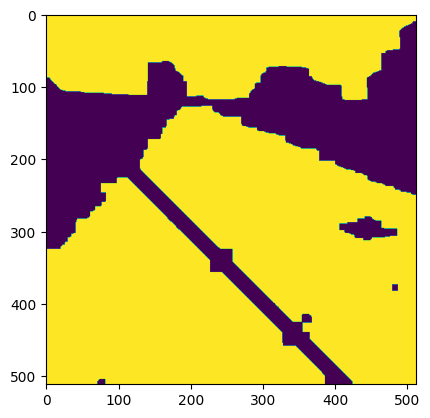

In [9]:
plt.imshow(closing)

In [10]:
print(closing.shape)

(512, 512)


In [ ]:
def generate_trapezoid_prediction(image):
    # Convert the image to grayscale
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection
    edges = cv2.Canny(image, 50, 150)
    
    # Find contours of the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a blank mask for the trapezoid prediction
    trapezoid_mask = np.zeros_like(edges)
    
    # Iterate through the contours and fit trapezoids
    for contour in contours:
        # Approximate the contour with a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx_polygon = cv2.approxPolyDP(contour, epsilon, True)
        
        # Fit trapezoid if the polygon has four vertices
        if len(approx_polygon) == 4:
            cv2.fillPoly(trapezoid_mask, [approx_polygon], 1)
    
    # Return the trapezoid prediction mask
    return trapezoid_mask

In [ ]:
import cv2
from sklearn.mixture import GaussianMixture

# Function to generate the probability map using Gaussian Mixture Models
def generate_probability_map(image):
    # Preprocess the image (resize, normalize, etc.) if necessary
    #preprocessed_image = preprocess_image(image)

    # Flatten the image to a 1D array
    flattened_image = image.flatten().reshape(-1, 1) #preprocessed_image.flatten().reshape(-1, 1)

    # Fit a Gaussian Mixture Model to the flattened image
    gmm = GaussianMixture(n_components=3)  # Assuming road and non-road classes
    gmm.fit(flattened_image)

    # Predict the probability of each pixel belonging to the road class
    probability_map = gmm.predict_proba(flattened_image)[:, 1].reshape(image.shape)#preprocessed_image.shape)

    return probability_map

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
import skfuzzy

# Step 4: Spatial fuzzy clustering
def fuzzy_clustering(image, trapezoid_prediction, probability_map, num_clusters):
    # Combine trapezoid prediction and probability map for road recognition
    combined_map = trapezoid_prediction * probability_map

    # Apply PCA for dimensionality reduction
    flattened_image = image.reshape(-1, image.shape[-1])
    pca = PCA(n_components=3)
    reduced_image = pca.fit_transform(flattened_image)

    # Perform fuzzy clustering using the FCM algorithm
    centers, u, _, _, _, _, _ = skfuzzy.cluster.cmeans(reduced_image.T, num_clusters, 2, error=0.005, maxiter=1000, init=None)

    # Assign each pixel to the cluster with the highest membership value
    labels = np.argmax(u, axis=0)

    # Map the cluster labels to the original image shape
    clustered_image = labels.reshape(image.shape[:2])
    #clustered_image = u.reshape(image.shape[:2])
    #return labels

    return clustered_image

In [ ]:
#image = cv2.imread('image.jpg')
trapezoid_prediction = generate_trapezoid_prediction(closing)
probability_map =generate_probability_map(closing)

# Step 4: Spatial fuzzy clustering
num_clusters = 3  # Number of clusters to identify
clustered_image = fuzzy_clustering(closing, trapezoid_prediction, probability_map, num_clusters)

print(clustered_image)
# Display the clustered image
#cv2.imshow("Clustered Image", clustered_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [29]:
import cv2
""" Image Segmentation """
imag = cv2.imread("Image12.jpg", cv2.IMREAD_UNCHANGED) 
#imag = cv2.imread("birds2.jpg", cv2.IMREAD_UNCHANGED)  
#imag = cv2.imread("peppers3.jpg", cv2.IMREAD_UNCHANGED)  
vectorized = imag.reshape((-1,3))
print(vectorized)

[[226 174 121]
 [226 174 121]
 [226 174 121]
 ...
 [108 137 164]
 [106 135 162]
 [117 146 173]]


In [ ]:
kmeans = KMeans(n_clusters=5, random_state = 0, n_init=5).fit(vectorized)
centers = np.uint8(kmeans.cluster_centers_)
segmented_data = centers[kmeans.labels_.flatten()]
 
segmented_image = segmented_data.reshape((imag.shape))
plt.imshow(segmented_image)
plt.pause(1)

In [ ]:
closing.shape

In [26]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [40]:
vectorized = closing.reshape((-1,))
print(vectorized.shape)
print(vectorized)

(262144,)
[255 255 255 ... 255 255 255]


In [39]:
# Define the number of clusters
n_clusters = 3
#print(len(closing.flatten()))
#vectorized = closing.reshape((-1,2))
# Apply fuzzy c-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(vectorized, n_clusters, 2, error=0.005, maxiter=1000, init=None)
 
# Predict cluster membership for each data point
cluster_membership = np.argmax(u, axis=0)
 
# Print the cluster centers
print('Cluster Centers:', cntr)
 
# Print the cluster membership for each data point
print('Cluster Membership:', cluster_membership)

ValueError: XA must be a 2-dimensional array.

In [ ]:
cluster_membership.shape

In [ ]:
segmented_data = centers[kmeans.labels_.flatten()]

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
 
# Generate some example data
np.random.seed(0)
data = np.random.rand(100, 2)
 
# Define the number of clusters
n_clusters = 3
 
# Apply fuzzy c-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, n_clusters, 2, error=0.005, maxiter=1000, init=None
)
 
# Predict cluster membership for each data point
cluster_membership = np.argmax(u, axis=0)
 
# Print the cluster centers
print('Cluster Centers:', cntr)
 
# Print the cluster membership for each data point
print('Cluster Membership:', cluster_membership)

In [ ]:
data.shape